In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data
Import the survey data from 2019 and filter for the observations for groundnuts.

In [102]:
data = pd.read_csv("../../data/clean_survey_data/2019_clean.csv", low_memory=False)
data.info()
nuts = data[data["groundnuts"] == 1]
nuts = nuts[nuts.columns.drop(list(nuts.filter(regex="so_.*")))]
nuts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Columns: 212 entries, id to cfvo_30-60cm_mean
dtypes: float64(160), int64(47), object(5)
memory usage: 738.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 445
Columns: 178 entries, id to cfvo_30-60cm_mean
dtypes: float64(126), int64(47), object(5)
memory usage: 601.3+ KB


### Land Productivity for Groundnuts
Visualization of the land productivity for groundnuts before and after removing unrealistic outliers.

In [103]:
# Visualization of yield

def visualize_yield(nuts):
    if max(nuts["gr_land_prod"]) > 2.5:
        outliers = True
        print("Before removing outliers")
    else:
        outliers = False
        print("After removing outliers")

    fig = plt.figure(figsize=(8,6))
    sns.histplot(nuts["gr_land_prod"], color="lightslategray")
    plt.title(f"Land productivity for groundnuts in 2019")
    plt.xlabel("Land productivity for groundnuts in tons/hectare")
    plt.show()
    #plt.savefig(f"../../figures/Histograms/groundnuts_outliers_{outliers}.png")
    
    # Yield per village
    fig = plt.figure(figsize=(12,7))
    sns.boxplot(data=nuts, x="gr_land_prod", y="village", palette="mako",
                order=nuts[["village", "gps_lat"]].groupby("village").min().sort_values(by="gps_lat", ascending=False).index.to_list())
    plt.title("Land productivity of groundnuts per Village", fontsize=16)
    plt.xlabel("Land productivity of groundnuts in tons/hectare", fontsize=16)
    plt.ylabel("Village", fontsize=16)
    plt.show()
    #plt.savefig(f"../../figures/Histograms/groundnuts_outliers_{outliers}_boxplot.png")
    
    # Yield plateau / valley
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(data=nuts, x="gr_land_prod", y="plateau_or_valley", palette="mako")
    plt.title("Land productivity of groundnuts")
    plt.xlabel("Land productivity of groundnuts in tons/hectare")
    plt.ylabel("")
    plt.show()

Before removing outliers


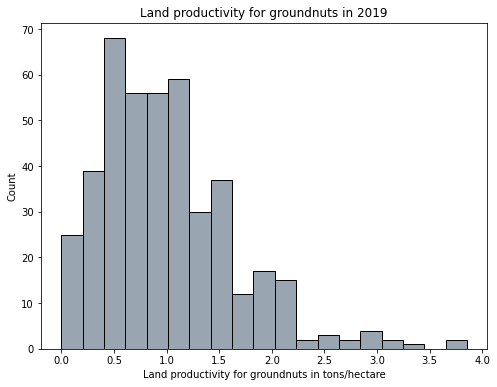

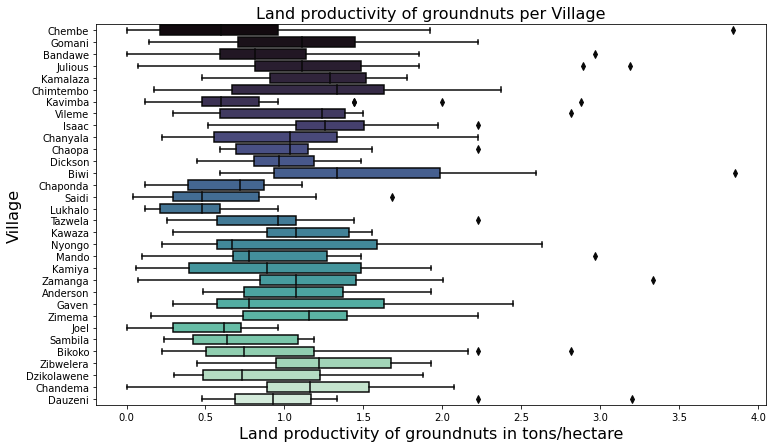

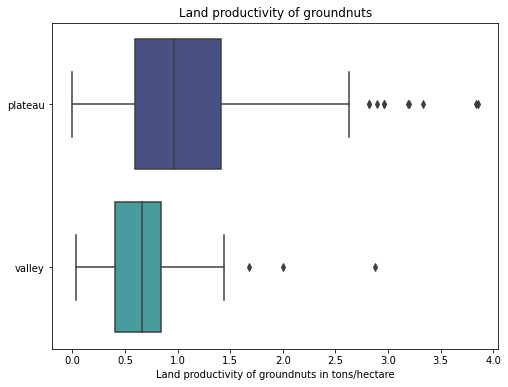

Removed 13 observations due to unrealistic yield value for groundnuts.
Number of observations left: 417
After removing outliers


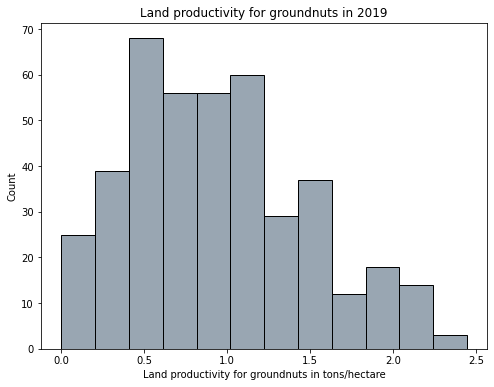

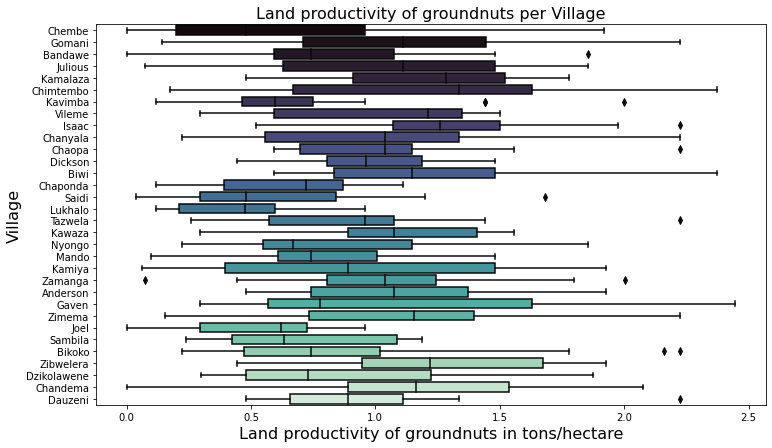

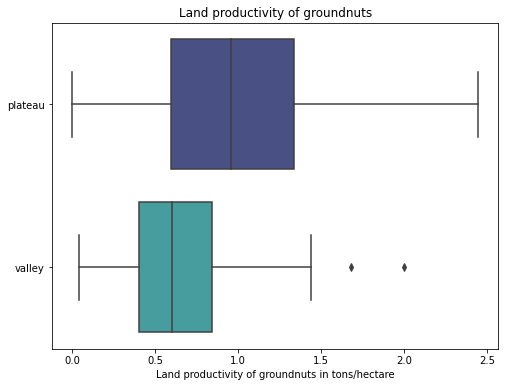

In [104]:
# Visualize yield with outliers
visualize_yield(nuts)

# Remove outliers
cnt_0 = nuts.shape[0]
nuts = nuts.loc[nuts["gr_land_prod"] <= 2.5]
cnt_1 = nuts.shape[0]
print(f"Removed {cnt_0-cnt_1} observations due to unrealistic yield value for groundnuts.\nNumber of observations left: {cnt_1}")

# Visualize yield without outliers
visualize_yield(nuts)

### Comparison of productivity to "normal" - Response from Farmers
In the survey, the farmers were asked to compare this year's yield to normal. If this year was worse than normal, they were further asked to give reasons.

In [18]:
# mapping color: green (good) to red (bad) and grey (neutral)
# color map
colormap_large = {
    1: "lightgray",
    2: "limegreen",
    3: "chartreuse",
    4: "orange",
    5: "crimson",
    6: "darkred"
}
# color map
colormap_small = {
    0: "lightgray",
    1: "chartreuse",
    2: "orange",
    3: "crimson"
}

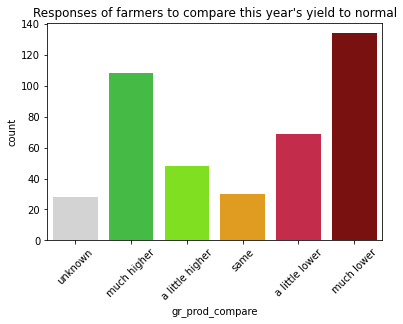

In [30]:
sns.countplot(data=nuts, x="gr_prod_compare", palette=colormap_large, order=[1,2,3,4,5,6])
plt.title("Responses of farmers to compare this year's yield to normal")
plt.xticks(ticks=[0,1,2,3,4,5],
           labels=["unknown", "much higher", "a little higher", "same", "a little lower", "much lower"],
           rotation=45)
plt.show()

Investigating this on a village level, we see a trend in some villages, such as in ...

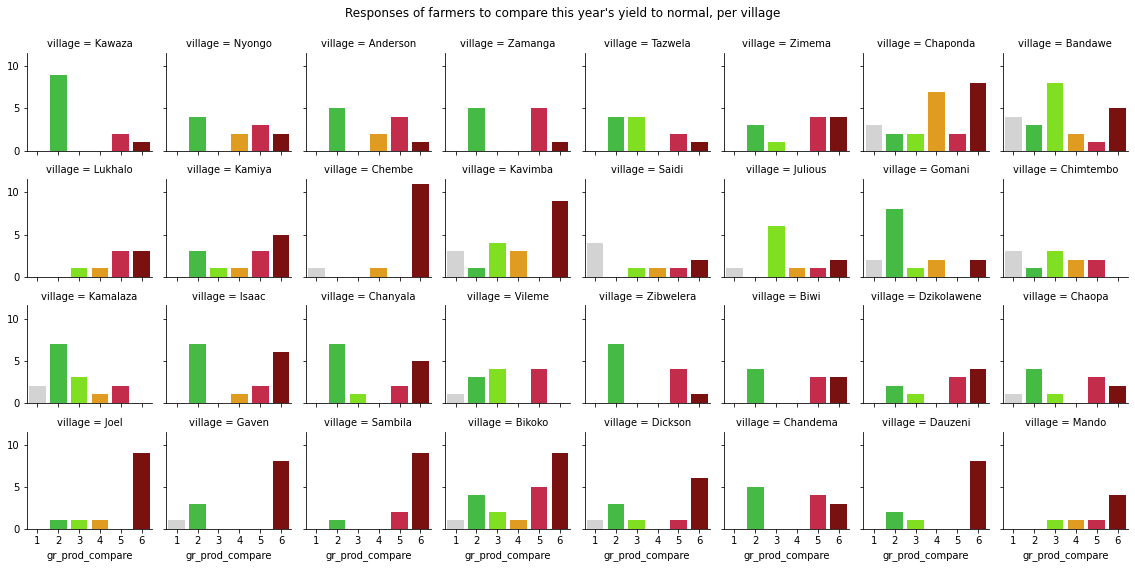

In [34]:
# Within one village, was the production better or worse? Is there a trend visible?
g = sns.FacetGrid(nuts, col="village", col_wrap=8, height=2)
g.map(sns.countplot, "gr_prod_compare", palette=colormap_large, order=[1,2,3,4,5,6])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Responses of farmers to compare this year's yield to normal, per village")
plt.show()

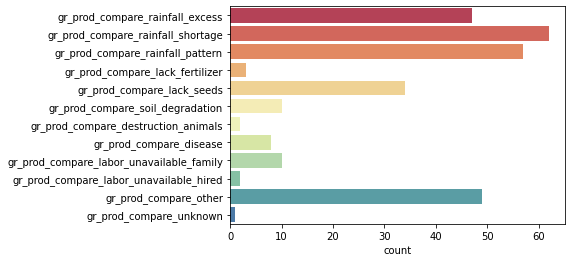

In [39]:
# Rainfall is one of the main rasons for decreased productivity
compare = ["gr_prod_compare_rainfall_excess", "gr_prod_compare_rainfall_shortage", "gr_prod_compare_rainfall_pattern",
           "gr_prod_compare_lack_fertilizer", "gr_prod_compare_lack_seeds", "gr_prod_compare_soil_degradation",
           "gr_prod_compare_destruction_animals", "gr_prod_compare_disease",
           "gr_prod_compare_labor_unavailable_family", "gr_prod_compare_labor_unavailable_hired",
           "gr_prod_compare_other", "gr_prod_compare_unknown"]
compare_reasons = pd.DataFrame(nuts[nuts["gr_prod_compare"] >= 5][compare].sum(), columns=["count"])
sns.barplot(data=compare_reasons, y=compare_reasons.index, x="count", palette="Spectral")
plt.show()

conclusion:
- rain excess: Anderson, Zamanga, Kamiya, Chembe, Kavimba, Julios, Kamalaza, Chimtembo, Dickson
- rain shortage: Tazwela, Bandawe, Lukhalo, Saidi, Dzikolawene, Biwi, Chaopa, Joel,
               Sambila, Bikoko, Chandema, Dauzeni, Mando

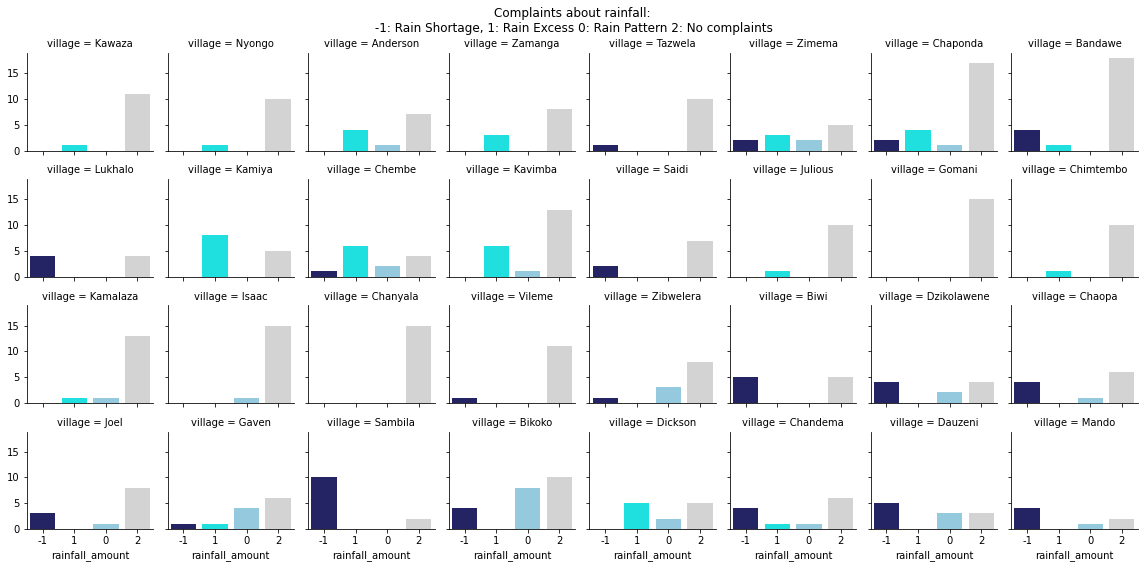

In [44]:
# check whether one farm claims both shortage and excess -> Nope (perfect)
len(nuts.loc[nuts["gr_prod_compare_rainfall_shortage"] + nuts["gr_prod_compare_rainfall_excess"] == 2]) == 0
# thus, we can put them together in one variable
nuts["rainfall_amount"] = nuts.apply(lambda row: 1 if row.gr_prod_compare_rainfall_excess == 1 else
                                     -1 if row.gr_prod_compare_rainfall_shortage == 1 else
                                     0 if row.gr_prod_compare_rainfall_pattern == 1 else
                                     2, axis=1)
colormap_rain = {
    2: "lightgray",
    0: "skyblue",
    1: "aqua",
    -1: "midnightblue"
}

# plot how many famers complain about rainfall (shortage / excess) per village
g = sns.FacetGrid(nuts, col="village", col_wrap=8, height=2)
g.map(sns.countplot, "rainfall_amount", order=[-1,1,0,2], palette=colormap_rain)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Complaints about rainfall:\n -1: Rain Shortage, 1: Rain Excess, 0: Rain Pattern, 2: No complaints")
plt.show()

### Workforce

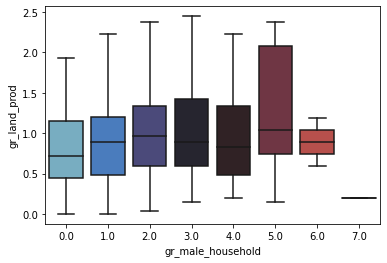

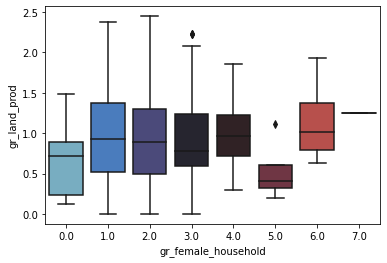

In [70]:
# Visualize correlation between household labor and yield
sns.boxplot(data=nuts, x="gr_male_household", y="gr_land_prod", palette="icefire")
plt.show()
sns.boxplot(data=nuts, x="gr_female_household", y="gr_land_prod", palette="icefire")
plt.show()

### Access to financial services

In [74]:
nuts[["financial_access", "id"]].groupby("financial_access").count()

id
financial_access     
0                 313
1                 104

<AxesSubplot:xlabel='financial_access', ylabel='gr_land_prod'>

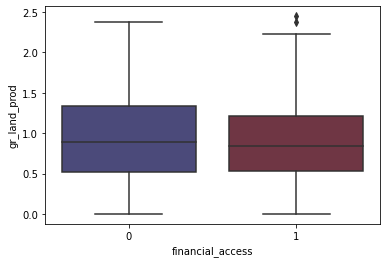

In [94]:
sns.boxplot(data=nuts, y="gr_land_prod", x="financial_access", palette="icefire")

<AxesSubplot:xlabel='financial_type_loan', ylabel='gr_land_prod'>

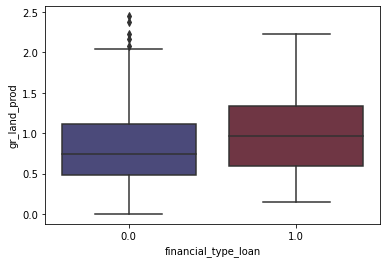

In [95]:
# the only visible correlation is this: if a farmer has access to financial services,
# then on average those with a loan yield a better produciton
sns.boxplot(data=nuts[nuts["financial_access"] == 1], x="financial_type_loan", y="gr_land_prod", palette="icefire")

### Radio COMACO

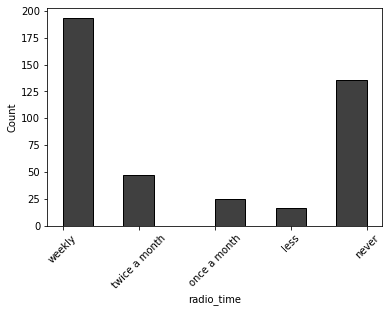

<AxesSubplot:xlabel='radio_time', ylabel='gr_land_prod'>

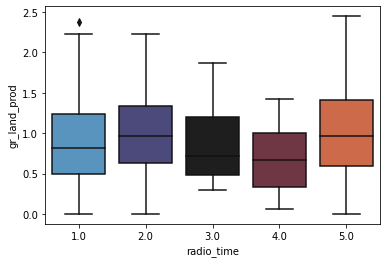

In [109]:
sns.histplot(nuts["radio_time"], color="black")
plt.xticks(ticks=[1,2,3,4,5], labels=["weekly", "twice a month", "once a month", "less", "never"],
          rotation=45)
plt.show()
sns.boxplot(data=nuts, x="radio_time", y="gr_land_prod", palette="icefire")

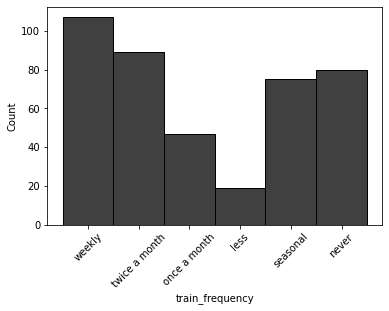

In [120]:
sns.histplot(nuts["train_frequency"], discrete=True, color="black")
plt.xticks(ticks=[1,2,3,4,5,6],
           labels=["weekly", "twice a month", "once a month", "less", "seasonal", "never"],
           rotation=45)
plt.show()

<AxesSubplot:xlabel='train_frequency', ylabel='gr_land_prod'>

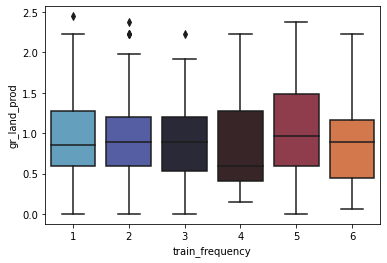

In [122]:
sns.boxplot(data=nuts, x="train_frequency", y="gr_land_prod", palette="icefire")

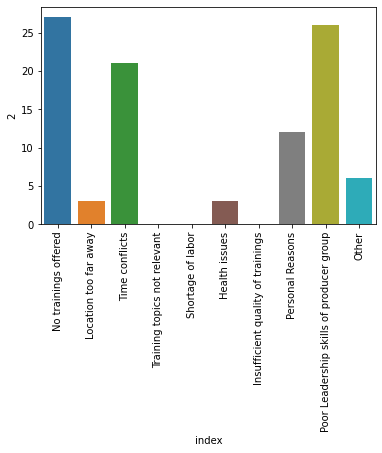

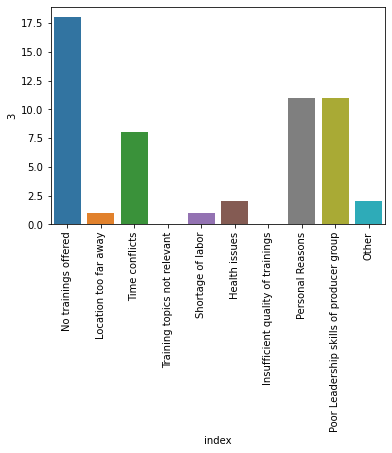

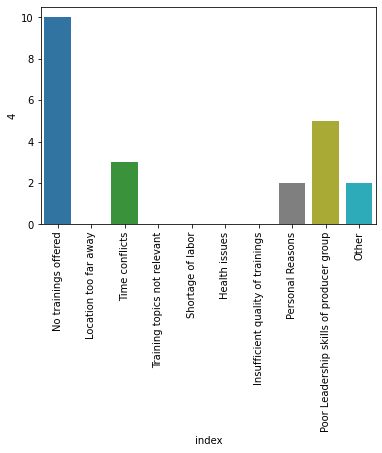

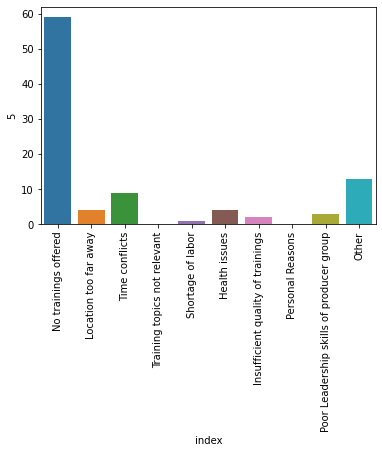

In [154]:
train_hinder = ["train_hinder_1", "train_hinder_2", "train_hinder_3", "train_hinder_4", "train_hinder_5",
                "train_hinder_6", "train_hinder_7", "train_hinder_8", "train_hinder_9", "train_hinder_97",
                "train_frequency"]
labels = {"train_hinder_1": "No trainings offered",
          "train_hinder_2": "Location too far away",
          "train_hinder_3": "Time conflicts",
          "train_hinder_4": "Training topics not relevant",
          "train_hinder_5": "Shortage of labor",
          "train_hinder_6": "Health issues",
          "train_hinder_7": "Insufficient quality of trainings",
          "train_hinder_8": "Personal Reasons",
          "train_hinder_9": "Poor Leadership skills of producer group",
          "train_hinder_97": "Other"}
for i in range (2,6):
    sns.barplot(data=nuts[train_hinder].groupby("train_frequency").sum().rename(columns=labels)
                .transpose().reset_index().rename(columns=labels), y=i, x="index")
    plt.xticks(rotation=90)
    plt.show()

### Tech Devices
We see a slight increase in the mean when the farmer has a tech device. However, the variation inside both groups is high.

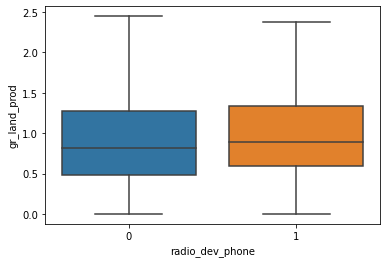

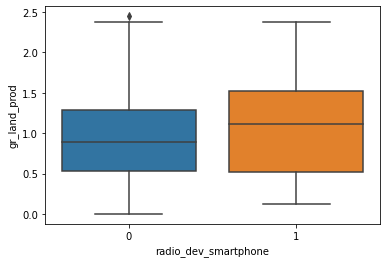

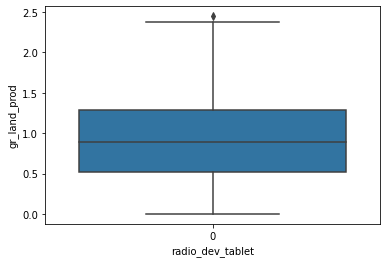

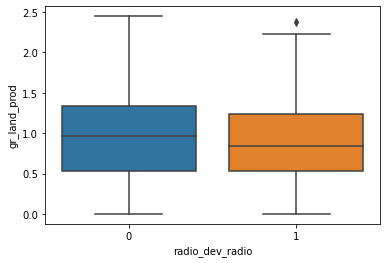

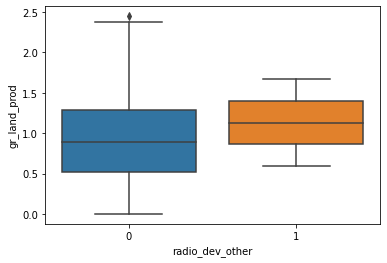

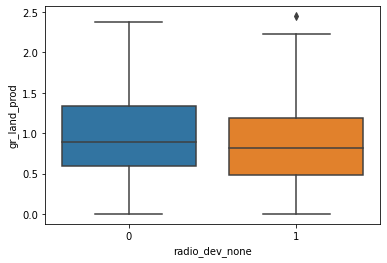

In [157]:
tech_devices = ['radio_dev_phone',
                'radio_dev_smartphone',
                'radio_dev_tablet',
                'radio_dev_radio',
                'radio_dev_other',
                'radio_dev_none']
for col in tech_devices:
    sns.boxplot(data=nuts, x=col, y="gr_land_prod")
    plt.show()